In [1]:
from datetime import datetime
import json
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Random
with open('pipelines_random.json') as f:
    pipelines_random = json.load(f)

# Round Robin
with open('pipelines_rr.json') as f:
    pipelines_rr = json.load(f)

# Custom
with open('pipelines_custom.json') as f:
    pipelines_custom = json.load(f)

### Total execution time

In [3]:
def total_execution_time(pipelines):
    submission_timestamps = []
    finish_timestamps = []
    for pipeline in pipelines:
        submitted_at = pipeline['submitted_at']
        submitted_at = datetime.fromisoformat(submitted_at)
        submission_timestamps.append(submitted_at)

        finished_at = pipeline['finished_at']
        finished_at = datetime.fromisoformat(finished_at)
        finish_timestamps.append(finished_at)

    start = min(submission_timestamps)
    end = max(finish_timestamps)
    delta = end - start
    return delta.total_seconds()


def pipeline_execution_times(pipelines):
    execution_times = []
    for pipeline in pipelines:
        submitted_at = pipeline['submitted_at']
        submitted_at = datetime.fromisoformat(submitted_at)

        finished_at = pipeline['finished_at']
        finished_at = datetime.fromisoformat(finished_at)

        delta = finished_at - submitted_at
        execution_times.append((pipeline["name"], delta.total_seconds()))
    return execution_times

Total execution time for Random placer: 549.676852 seconds
Total execution time for Round Robin placer: 447.876921 seconds
Total execution time for Custom placer: 360.821494 seconds


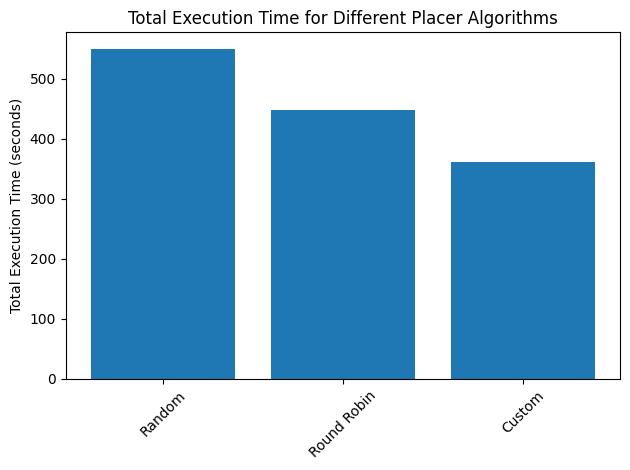

In [4]:
# Random
total_time = total_execution_time(pipelines_random)
print(f"Total execution time for Random placer: {total_time} seconds")

# Round Robin
total_time = total_execution_time(pipelines_rr)
print(f"Total execution time for Round Robin placer: {total_time} seconds")

# Custom
total_time = total_execution_time(pipelines_custom)
print(f"Total execution time for Custom placer: {total_time} seconds")

# Plotting
labels = ['Random', 'Round Robin', 'Custom']
times = [
    total_execution_time(pipelines_random),
    total_execution_time(pipelines_rr),
    total_execution_time(pipelines_custom)
]
plt.bar(labels, times)
plt.ylabel('Total Execution Time (seconds)')
plt.title('Total Execution Time for Different Placer Algorithms')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

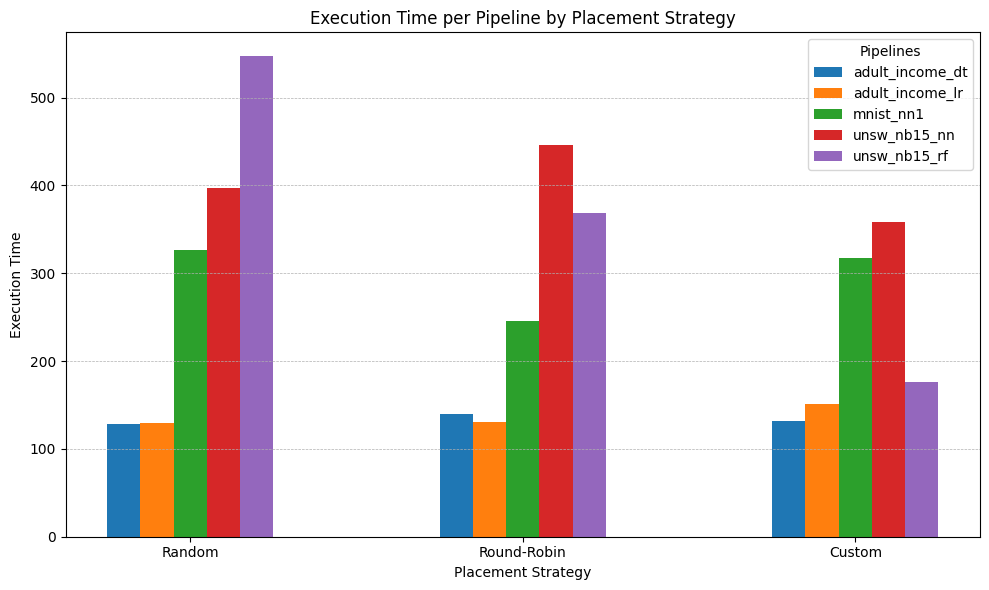

In [5]:
pipeline_times_random = pipeline_execution_times(pipelines_random)
pipeline_times_rr = pipeline_execution_times(pipelines_rr)
pipeline_times_custom = pipeline_execution_times(pipelines_custom)

# Get the pipeline names and their corresponding execution times
pipeline_names = [name for name, _ in pipeline_times_random]
strategies = ['Random', 'Round-Robin', 'Custom']
pipeline_count = len(pipeline_names)
bar_width = 0.10

# Organize times per strategy
times_random = [time for _, time in pipeline_times_random]
times_rr = [time for _, time in pipeline_times_rr]
times_custom = [time for _, time in pipeline_times_custom]

# Create data matrix: each row is a strategy, each column is a pipeline
data = np.array([times_random, times_rr, times_custom])

# X positions for each strategy group
x = np.arange(len(strategies))

# Create bar plot
fig, ax = plt.subplots(figsize=(10, 6))

for i in range(pipeline_count):
    ax.bar(
        x + (i - pipeline_count/2) * bar_width + bar_width/2,  # center around group
        data[:, i],
        width=bar_width,
        label=pipeline_names[i]
    )

# Labeling
ax.set_xlabel('Placement Strategy')
ax.set_ylabel('Execution Time')
ax.set_title('Execution Time per Pipeline by Placement Strategy')
ax.set_xticks(x)
ax.set_xticklabels(strategies)
ax.legend(title='Pipelines')
ax.grid(axis='y', linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.show()


### Total waiting time

In [6]:
def total_waiting_time(pipelines):
    waiting_times = []

    for pipeline in pipelines:
        submitted_at = pipeline['submitted_at']
        submitted_at = datetime.fromisoformat(submitted_at)
        
        scheduled_at = pipeline['scheduled_at']
        scheduled_at = datetime.fromisoformat(scheduled_at)
        
        delta = scheduled_at - submitted_at
        waiting_times.append(delta.total_seconds())
    
    return sum(waiting_times)


def pipeline_waiting_times(pipelines):
    execution_times = []
    for pipeline in pipelines:
        submitted_at = pipeline['submitted_at']
        submitted_at = datetime.fromisoformat(submitted_at)

        scheduled_at = pipeline['scheduled_at']
        scheduled_at = datetime.fromisoformat(scheduled_at)

        delta = scheduled_at - submitted_at
        execution_times.append((pipeline["name"], delta.total_seconds()))
    return execution_times

Total waiting time for Random placer: 595.334995 seconds
Total waiting time for Round Robin placer: 272.469273 seconds
Total waiting time for Custom placer: 81.104839 seconds


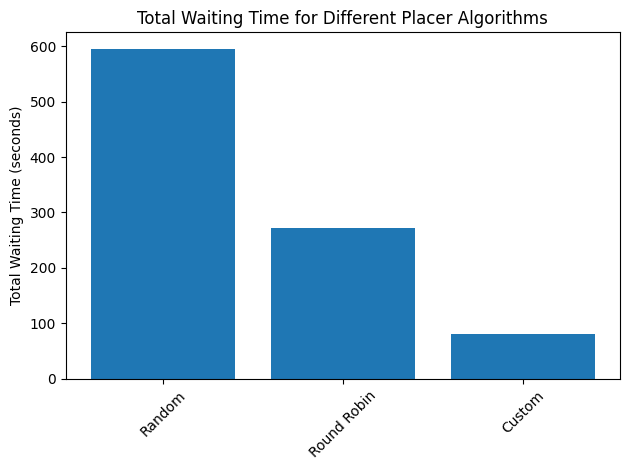

In [7]:
# Random
waiting_time = total_waiting_time(pipelines_random)
print(f"Total waiting time for Random placer: {waiting_time} seconds")

# Round Robin
waiting_time = total_waiting_time(pipelines_rr)
print(f"Total waiting time for Round Robin placer: {waiting_time} seconds")

# Custom
waiting_time = total_waiting_time(pipelines_custom)
print(f"Total waiting time for Custom placer: {waiting_time} seconds")

# Plotting
labels = ['Random', 'Round Robin', 'Custom']
times = [
    total_waiting_time(pipelines_random),
    total_waiting_time(pipelines_rr),
    total_waiting_time(pipelines_custom)
]
plt.bar(labels, times)
plt.ylabel('Total Waiting Time (seconds)')
plt.title('Total Waiting Time for Different Placer Algorithms')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

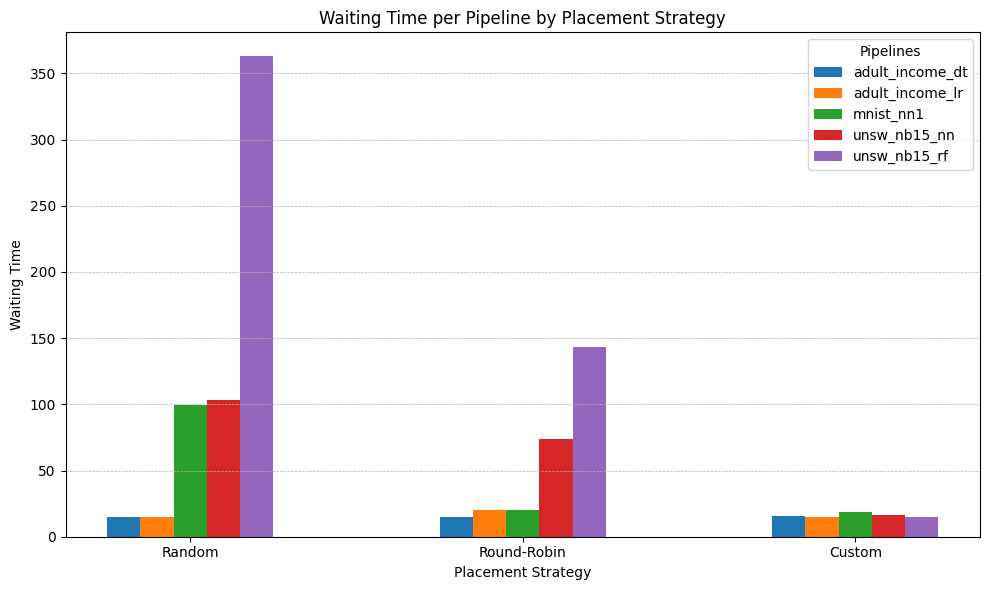

In [8]:
pipeline_times_random = pipeline_waiting_times(pipelines_random)
pipeline_times_rr = pipeline_waiting_times(pipelines_rr)
pipeline_times_custom = pipeline_waiting_times(pipelines_custom)

# Get the pipeline names and their corresponding execution times
pipeline_names = [name for name, _ in pipeline_times_random]
strategies = ['Random', 'Round-Robin', 'Custom']
pipeline_count = len(pipeline_names)
bar_width = 0.10

# Organize times per strategy
times_random = [time for _, time in pipeline_times_random]
times_rr = [time for _, time in pipeline_times_rr]
times_custom = [time for _, time in pipeline_times_custom]

# Create data matrix: each row is a strategy, each column is a pipeline
data = np.array([times_random, times_rr, times_custom])

# X positions for each strategy group
x = np.arange(len(strategies))

# Create bar plot
fig, ax = plt.subplots(figsize=(10, 6))

for i in range(pipeline_count):
    ax.bar(
        x + (i - pipeline_count/2) * bar_width + bar_width/2,  # center around group
        data[:, i],
        width=bar_width,
        label=pipeline_names[i]
    )

# Labeling
ax.set_xlabel('Placement Strategy')
ax.set_ylabel('Waiting Time')
ax.set_title('Waiting Time per Pipeline by Placement Strategy')
ax.set_xticks(x)
ax.set_xticklabels(strategies)
ax.legend(title='Pipelines')
ax.grid(axis='y', linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.show()